<a href="https://colab.research.google.com/github/AK18k/GMVAE-master/blob/main/GMVAE_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="center">
  <td align="center"><a target="_blank" href="https://github.com/jariasf/GMVAE/tree/master/pytorch">
        <img src="http://introtodeeplearning.com/images/colab/github.png"  height="70px" style="padding-bottom:5px;"  />
    <br>View Source on GitHub</a></td>
  
  <td align="center"><a target="_blank" href="https://colab.research.google.com/drive/173A4-xUYCVnc8nKCy1syKRJi7rw8B38V">
        <img src="https://www.gstatic.com/devrel-devsite/v741200ba74cbd1989790411f8b27fb588884a771dac0e0472d95190dde1f7e2f/tensorflow/images/lockup.svg"  height="70px" style="padding-bottom:5px;"  /><br>View TensorFlow Version</a></td>
  
</table>

# Gaussian Mixture Variational Autoencoder

**Author:** Jhosimar George Arias Figueroa

This notebook contains a pytorch implementation of a Gaussian Mixture Variational Autoencoder (GMVAE) applied to unsupervised clustering. The model is based on the M2 Unsupervised model proposed by Kingma et al. (https://arxiv.org/pdf/1406.5298), where instead of marginalization of the categorical variable, we use the Gumbel-Softmax distribution (https://arxiv.org/pdf/1611.01144) and modify the generative model to represent a Mixture of Gaussians.

## Load Source Code from Github

In [2]:
# clone the github repository to access source code
!git clone https://github.com/AK18k/GMVAE-master

# set the correct directory
%cd GMVAE-master/pytorch

fatal: destination path 'GMVAE-master' already exists and is not an empty directory.
/content/GMVAE-master/pytorch


## Install Latest Version of Pytorch

In [33]:
# tested with torch-1.3.0 torchvision-0.4.1
!pip install --upgrade torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Libraries

In [35]:
import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat
from model.GMVAE import *
import matplotlib.pyplot as plt
%matplotlib inline

## Input Parameters

In [ ]:
#########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=5,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int,
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=10,
                    help='number of classes (default: 10)')
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=784, type=int,
                    help='input size (default: 784)')

## Partition parameters
parser.add_argument('--train_proportion', default=1.0, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int,
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int,
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float,
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [36]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
  torch.cuda.manual_seed(SEED)

## MNIST Dataset

The MNIST dataset consists of 70000 handwritten digits of 28×28 pixel size and 10 classes, of which 60000 images are considered for training and 10000 images for testing. This dataset can be obtained directly from the [torchvision](https://pytorch.org/docs/stable/torchvision/datasets.html) framework.

In [37]:
print("Loading mnist dataset...")

# load mnist data
train_dataset = datasets.MNIST('./mnist', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./mnist', train=False, transform=transforms.ToTensor())

# print dataset shape
print('Train size: ', len(train_dataset), ' Test size: ', len(test_dataset))

Loading mnist dataset...
Train size:  60000  Test size:  10000


Let's visualize what the training data looks like:

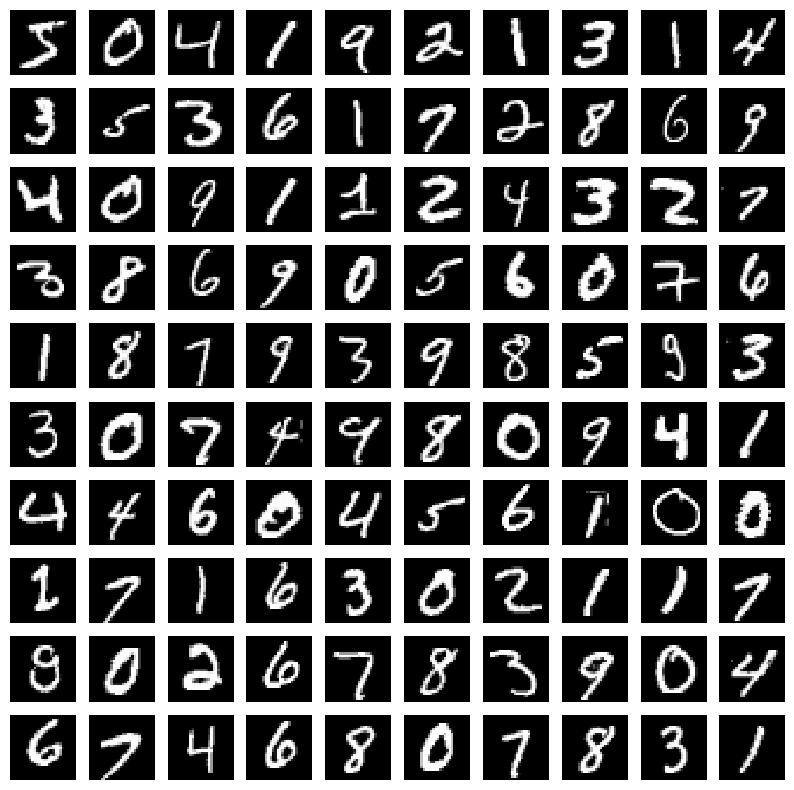

In [38]:
plt.figure(figsize=[10,10])
for i in range(0,100):
    plt.subplot(10,10,i+1)
    plt.imshow(np.reshape(train_dataset[i][0], (28,28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [39]:
def partition_dataset(n, proportion=0.8):
  train_num = int(n * proportion)
  indices = np.random.permutation(n)
  train_indices, val_indices = indices[:train_num], indices[train_num:]
  return train_indices, val_indices

if args.train_proportion == 1.0:
  # we use all train dataset without partitioning
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)
  val_loader = test_loader
else:
  # partition dataset according to train_proportion
  train_indices, val_indices = partition_dataset(len(train_dataset), args.train_proportion)
  # create data loaders for train, validation and test datasets
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
  val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)


## Train Model

In [40]:
# Model Initialization
gmvae = GMVAE(args)

In [41]:
# Training Phase
history_loss = gmvae.train(train_loader, val_loader)

(Epoch 1 / 5) Train_Loss: 176.182; Val_Loss: 146.536   Train_ACC: 37.545; Val_ACC: 54.920   Train_NMI: 24.383; Val_NMI: 49.808
(Epoch 2 / 5) Train_Loss: 139.377; Val_Loss: 133.115   Train_ACC: 54.562; Val_ACC: 57.190   Train_NMI: 51.630; Val_NMI: 56.997
(Epoch 3 / 5) Train_Loss: 131.338; Val_Loss: 128.574   Train_ACC: 58.625; Val_ACC: 61.200   Train_NMI: 56.589; Val_NMI: 59.534
(Epoch 4 / 5) Train_Loss: 127.501; Val_Loss: 125.966   Train_ACC: 61.760; Val_ACC: 63.650   Train_NMI: 58.797; Val_NMI: 60.977
(Epoch 5 / 5) Train_Loss: 125.180; Val_Loss: 123.688   Train_ACC: 64.483; Val_ACC: 66.280   Train_NMI: 60.761; Val_NMI: 62.964


## Test Data

In [42]:
accuracy, nmi = gmvae.test(test_loader)

print("Testing phase...")
print("Accuracy: %.5lf,  NMI: %.5lf" % (accuracy, nmi) )

Testing phase...
Accuracy: 66.28000,  NMI: 62.96365


## Image Reconstruction

In [43]:
def display_reconstructed(original, reconstructed, n=10):
  plt.figure(figsize=[18,2])
  for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(original[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')

    if reconstructed is not None:
      plt.subplot(2, n, i + n + 1)
      plt.imshow(reconstructed[i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()

original, reconstructed = gmvae.reconstruct_data(test_loader, 15)
display_reconstructed(original, reconstructed, 15)

AttributeError: ignored

## Random Generation per Category

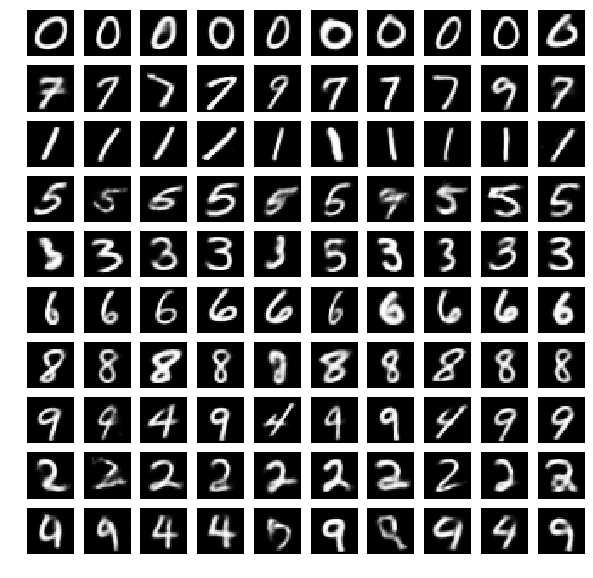

In [ ]:
def display_random_generation(generated, num_classes, n=10):
  plt.figure(figsize=[10,10])
  for c in range(num_classes):
    for i in range(n):
      plt.subplot(num_classes, n, (c * n) + i + 1)
      plt.imshow(generated[(c * n) + i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.show()

elem_per_category = 10
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

## Visualization of the feature latent space

In [ ]:
# get feature representations
test_features, test_labels = gmvae.latent_features(test_loader, True)

In [ ]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm
tsne_features = TSNE(n_components=2).fit_transform(test_features[:1000,])

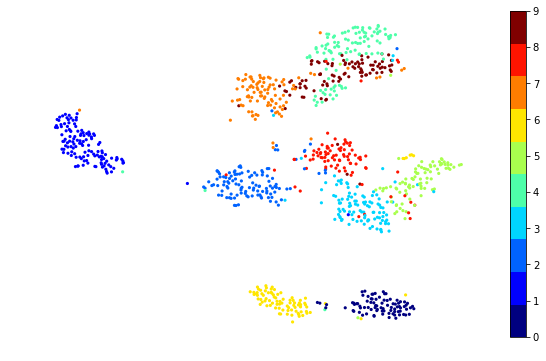

In [ ]:
fig = plt.figure(figsize=(10, 6))

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_labels[:tsne_features.shape[0]], marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.grid(False)
plt.axis('off')
plt.colorbar()